# QuTiP lecture: simulation of a two-qubit gate using a resonator as coupler

Author: J.R. Johansson, robert@riken.jp

http://dml.riken.jp/~rob/

Latest version of this ipython notebook lecture are available at: http://github.com/jrjohansson/qutip-lectures

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *

In [45]:
from qutip import *

## Parameters

In [46]:
N = 10

wc = 5.0 * 2 * pi
w1 = 3.0 * 2 * pi
w2 = 2.0 * 2 * pi

g1 = 0.01 * 2 * pi
g2 = 0.0125 * 2 * pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1 * pi) / (4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2 * pi) / (4 * g2)

### Operators, Hamiltonian and initial state 

In [47]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [48]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 

In [49]:
H

Quantum object: dims = [[10, 2, 2], [10, 2, 2]], shape = [40, 40], type = oper, isherm = True
Qobj data =
[[ -15.70796327    0.            0.         ...,    0.            0.            0.        ]
 [   0.           -3.14159265    0.         ...,    0.            0.            0.        ]
 [   0.            0.            3.14159265 ...,    0.            0.            0.        ]
 ..., 
 [   0.            0.            0.         ...,  279.60174617    0.            0.        ]
 [   0.            0.            0.         ...,    0.          285.88493148
     0.        ]
 [   0.            0.            0.         ...,    0.            0.
   298.45130209]]

In [50]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0), basis(2,1), basis(2,0))

# Ideal two-qubit iSWAP gate

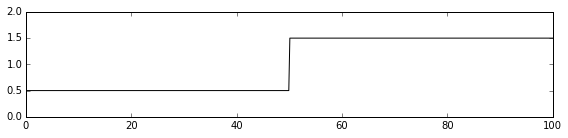

In [51]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [52]:
def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

### Evolve the system

In [53]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

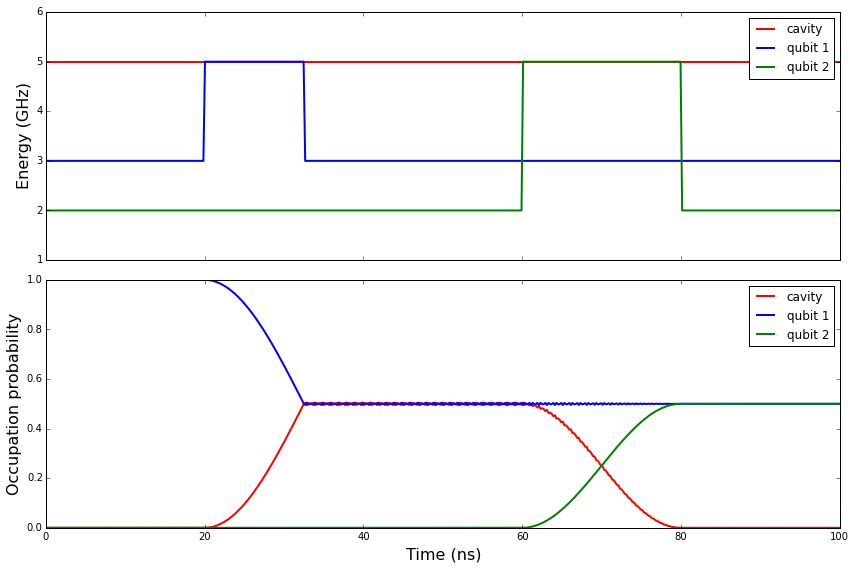

In [54]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Inspect the final state

In [55]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

In [56]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[  6.23619654e-05+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j           5.00063399e-01+0.j
   -4.99573000e-01+0.01989043j   0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j          -4.99573000e-01-0.01989043j
    4.99874239e-01+0.j           0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j        ]]

In [57]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-np.pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

### Fidelity and concurrence

In [58]:
fidelity(rho_qubits, rho_qubits_ideal)

0.01989521175026903

In [59]:
concurrence(rho_qubits)

0.99993761466744846

# Dissipative two-qubit iSWAP gate

### Define collapse operators that describe dissipation



In [23]:
kappa = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]

### Evolve the system

In [24]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot the results

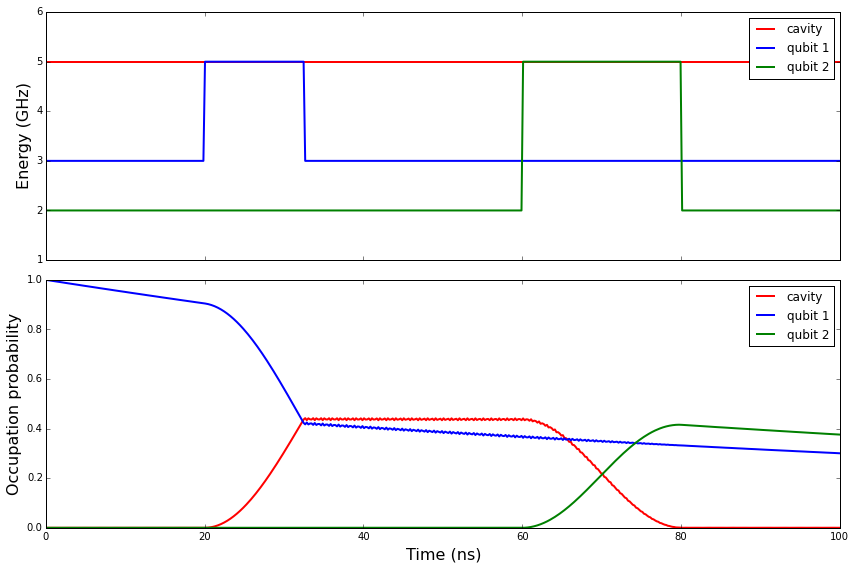

In [27]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [28]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [29]:
fidelity(rho_qubits, rho_qubits_ideal)

2.838633619828279e-09

In [30]:
concurrence(rho_qubits)

0.67237860360915169

# Two-qubit iSWAP gate: Finite pulse rise time

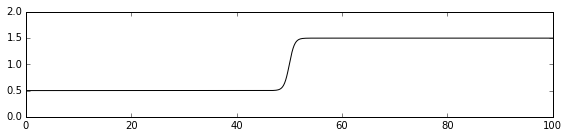

In [32]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time defined
    by the parameter width.
    """
    return w1 + (w2 - w1) / (1 + exp(-(t-t0)/width))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [33]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

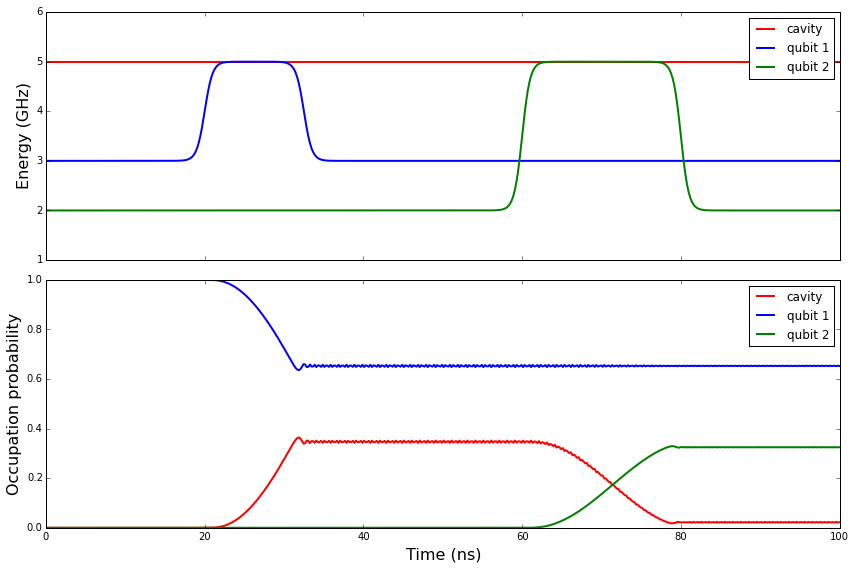

In [34]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [35]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [36]:
fidelity(rho_qubits, rho_qubits_ideal)

0.17500508035809387

In [37]:
concurrence(rho_qubits)

0.92122640978789305

# Two-qubit iSWAP gate: Finite rise time with overshoot

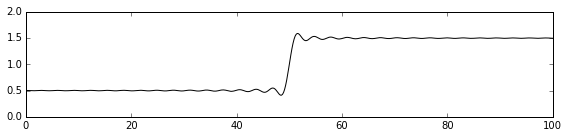

In [38]:
from scipy.special import sici

def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time and 
    and overshoot defined by the parameter width.
    """

    return w1 + (w2-w1) * (0.5 + sici((t-t0)/width)[0]/(pi))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [39]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

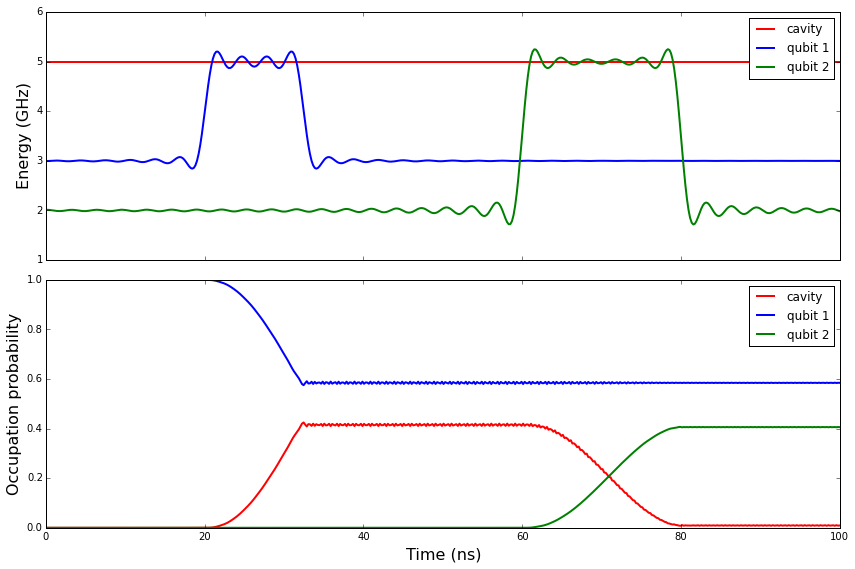

In [40]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [41]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [42]:
fidelity(rho_qubits, rho_qubits_ideal)

0.10568180682984239

In [43]:
concurrence(rho_qubits)

0.97438839024825852

# Two-qubit iSWAP gate: Finite pulse rise time and dissipation

In [24]:
# increase the pulse rise time a bit
width = 0.6

# high-Q resonator but dissipative qubits
kappa  = 0.00001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [sqrt(kappa) * a, sqrt(gamma1) * sm1, sqrt(gamma2) * sm2]

### Evolve the system

In [25]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot results

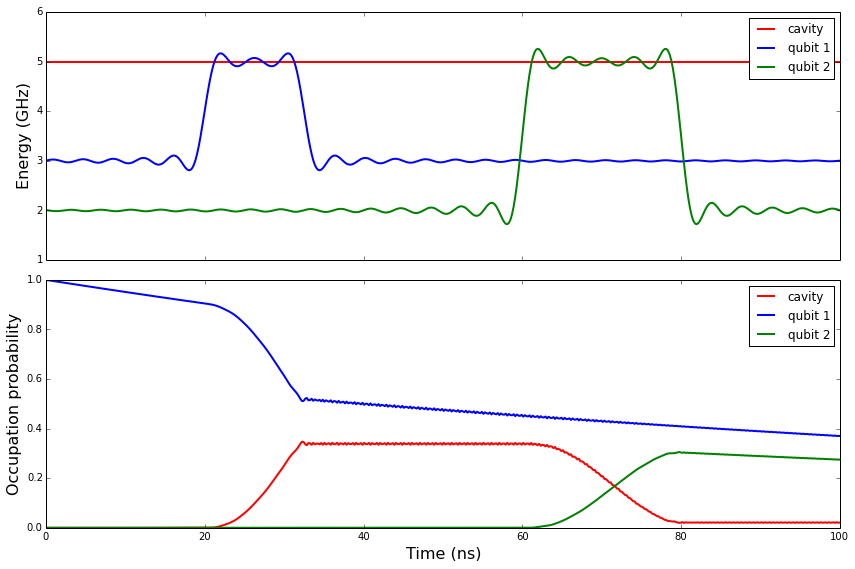

In [26]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [38]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [39]:
fidelity(rho_qubits, rho_qubits_ideal)

0.7943108372320334

In [40]:
concurrence(rho_qubits)

0.62615691287517516

# Two-qubit iSWAP gate: Using tunable resonator and fixed-frequency qubits

In [27]:
# reduce the rise time
width = 0.25

def wc_t(t, args=None):
    return wc - step_t(0.0, wc-w1, T0_1, width, t) + step_t(0.0, wc-w1, T0_1+T_gate_1, width, t) \
              - step_t(0.0, wc-w2, T0_2, width, t) + step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)

H_t = [[Hc, wc_t], H1 * w1 + H2 * w2 + Hc1+Hc2]

### Evolve the system

In [28]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot the results

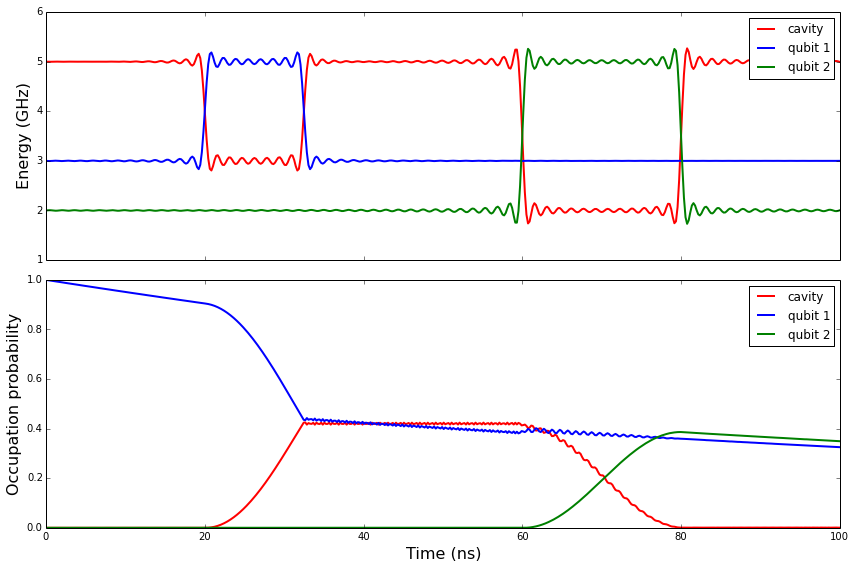

In [29]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [44]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [45]:
fidelity(rho_qubits, rho_qubits_ideal)

0.8209803465743701

In [46]:
concurrence(rho_qubits)

0.67365901098917069

### Software versions

In [30]:
from qutip.ipynbtools import version_table

version_table()